In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from sentence_transformers import LoggingHandler, util
from datetime import datetime
from sentence_transformers.cross_encoder import CrossEncoder
from torch.utils.data import DataLoader
from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator, CEBinaryClassificationEvaluator
import gzip
import os
import tarfile
from sentence_transformers import InputExample, losses
from datetime import datetime

In [2]:
#### Just some code to print debug information to stdout
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)
#### /print debug information to stdout

In [3]:
# query
query_train = pd.read_csv("./output/query_train_set_with_passage_info_14000.csv")
query_val =pd.read_csv("./output/query_val_set_with_passage_info_6000.csv")
query_test =pd.read_csv("./output/query_test_set_with_passage_info.csv")



# passage
passage_train = pd.read_csv("./output/train_passage_id_content_cleaned.csv")
passage_test = pd.read_csv("./output/test_passage_id_content_cleaned.csv")



In [4]:
print(passage_train.shape)
print(passage_test.shape)

(19898, 4)
(19893, 4)


In [5]:
# from sklearn.model_selection import train_test_split

# query_train, query_val = train_test_split(query_train, test_size=0.3)

In [6]:
query_train.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,413331,is israel a desert?,Q0,msmarco_passage_17_508217299,1,10.480900,Anserini,1,is israel a desert
1,830377,what is the maximum limit for cash while trave...,Q0,msmarco_passage_41_344156877,92,10.648500,Anserini,0,what is the maximum limit for cash while trave...
2,1019048,which sentence is written in the active voice?,Q0,msmarco_passage_35_731219214,7,14.647100,Anserini,1,which sentence is written in the active voice
3,1164109,what county is belton missouri in,Q0,msmarco_passage_53_115898775,97,10.780499,Anserini,0,what county is belton missouri in
4,629100,what does a green dot by a name on facebook mean,Q0,msmarco_passage_22_273231895,1,19.807899,Anserini,1,what does a green dot by a name on facebook mean


In [7]:
query_val.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,62551,can a landlord change the locks,Q0,msmarco_passage_25_703318235,3,13.5804,Anserini,1,can a landlord change the locks
1,717994,what is anhydrous borax,Q0,msmarco_passage_09_477910738,5,13.8030,Anserini,1,what is anhydrous borax
2,637523,what does fertilizer do,Q0,msmarco_passage_47_243186971,1,11.6778,Anserini,1,what does fertilizer do
3,151111,different types poison,Q0,msmarco_passage_09_559446520,94,8.5223,Anserini,0,different types poison
4,101517,cost for vudu,Q0,msmarco_passage_62_419649434,2,9.9570,Anserini,1,cost for vudu


In [8]:
query_test.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_05_840839268,1,16.004101,Anserini,1,what us state bears the slogan the land enchan...
1,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_06_203354916,2,15.715500,Anserini,1,what us state bears the slogan the land enchan...
2,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_45_489369159,3,15.715499,Anserini,1,what us state bears the slogan the land enchan...
3,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_50_676325639,4,14.983700,Anserini,1,what us state bears the slogan the land enchan...
4,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_21_464076261,5,14.347200,Anserini,1,what us state bears the slogan the land enchan...


In [9]:
print(query_train.shape)
print(query_val.shape)
print(query_test.shape)

(14000, 9)
(6000, 9)
(20000, 9)


In [10]:
passage_train.head()

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized
0,msmarco_passage_03_496902198,Let’s dig a little deeper into each. Hues are ...,let s dig a little deeper into each hues are c...,let s dig little deeply hue color hue dependen...
1,msmarco_passage_35_561149885,Let’s dig a little deeper into each. Hues are ...,let s dig a little deeper into each hues are c...,let s dig little deeply hue color hue dependen...
2,msmarco_passage_05_224676265,Hue: This is what we usually mean when we ask ...,hue this is what we usually mean when we ask w...,hue usually mean ask color property color actu...
3,msmarco_passage_04_168335684,hue = color or a shade of color\nexample sente...,hue color or a shade of color example sentence...,hue color shade color example sentence baby sk...
4,msmarco_passage_02_769341954,Hue: Hue is what we normally think of as color...,hue hue is what we normally think of as color ...,hue hue normally think color technically hue d...


In [11]:
query_train.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,413331,is israel a desert?,Q0,msmarco_passage_17_508217299,1,10.480900,Anserini,1,is israel a desert
1,830377,what is the maximum limit for cash while trave...,Q0,msmarco_passage_41_344156877,92,10.648500,Anserini,0,what is the maximum limit for cash while trave...
2,1019048,which sentence is written in the active voice?,Q0,msmarco_passage_35_731219214,7,14.647100,Anserini,1,which sentence is written in the active voice
3,1164109,what county is belton missouri in,Q0,msmarco_passage_53_115898775,97,10.780499,Anserini,0,what county is belton missouri in
4,629100,what does a green dot by a name on facebook mean,Q0,msmarco_passage_22_273231895,1,19.807899,Anserini,1,what does a green dot by a name on facebook mean


In [12]:
def df_to_list(query_df, passage_df):
    # returns a list of list
    # each sample have a list of [query, passage, score, rel]
    list_query_passage_score_rel = []
    for index, row in query_df.iterrows():
        list = []
        list.append(row['query'])
        list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
        list.append(row["score"])
        list.append(row["rel"])
        list_query_passage_score_rel.append(list)
    return list_query_passage_score_rel

In [13]:
list_query_passage_score_rel_train = df_to_list(query_train, passage_train)

In [14]:
print(len(list_query_passage_score_rel_train))
list_query_passage_score_rel_train[0:3]

14000


[['is israel a desert?',
  'Nefud Desert - a desert in northern part of the Arabian Peninsula. Ramlat al-Sab`atayn - a desert in north-central Yemen. Wahiba Sands - a desert covering great parts of Oman. Aerial view of Negev. Judaean Desert – a desert in eastern Israel and the West Bank. Negev – a desert located in southern Israel.',
  10.4809,
  1],
 ['what is the maximum limit for cash while traveling in usa',
  'A. Carry-on baggage limit for Frontier Airlines includes maximum weight limit of 35lbs and maximum dimensions of 10+16+24 inches (L+W+H). Q. What is Frontier Miles? A. Frontier Miles is the loyalty program especially designed for those who travel frequently with the airline.',
  10.6485,
  0],
 ['which sentence is written in the active voice?',
  'Summary. In a sentence written in the active voice, the subject of sentence performs the action. In a sentence written in the passive voice the subject receives the action. Active is used for most non-scientific writing.',
  14.647

In [15]:
# def produce_evaluation_list(list_qid_eval, query_df, passage_df):
#     list_eval = []
#     for qid in list_qid_eval:
#         dev_samples = {}
#         #print(qid)
#         query_all_passage_subset = query_df[query_df["query_id"] == qid]

        
#         #display(query_all_passage_subset)
        
#         dev_samples["query"] = query_all_passage_subset["query"].iloc[0]
#         dev_samples["positive"] = set()
#         dev_samples["negative"] = set()
#         #print(dev_samples)
#         for index, row in query_all_passage_subset.iterrows():
#             #display(passage_df[passage_df['passage_id'] == row['passage_id']])

#             if row['rel'] == 1:
#                 dev_samples["positive"].add(
#                     passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
#             elif row['rel'] == 0:
#                 dev_samples["negative"].add(
#                     passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
#         #print(dev_samples)
#         list_eval.append(dev_samples)
#     return list_eval

In [16]:
# list_eval = produce_evaluation_list(list_qid_eval = query_val["query_id"].unique()
# , query_df = query_val
# , passage_df = passage_train)


In [17]:
list_eval = df_to_list(query_val, passage_train)

In [19]:
print(len(list_eval))
list_eval[0:3]


6000


[['can a landlord change the locks',
  'Changing the Locks in New Hampshire. Landlords are prohibited from changing locks without the tenants permission and tenants can request a lock change if they are the victim of domestic abuse and the landlord must cover the cost of changing the locks.',
  13.5804,
  1],
 ['what is anhydrous borax',
  'Borax Anhydrous puriss. p.a., anhydrous, >= 98.0 % T | 1330-43-4 | Sigma-Aldrich. Sial-71996; Borax Anhydrous puriss. p.a., anhydrous, >=98.0% (T); CAS No.: 1330-43-4; Synonyms: Sodium tetraborate; Linear Formula: Na2B4O7; Empirical Formula: B4Na2O7; find related products, papers, technical documents, MSDS & more at Sigma-Aldrich. ADVANCED SEARCH.',
  13.803,
  1],
 ['what does fertilizer do',
  'Weeds. Houseplants. You are here: Home / Gardening How-To / Soil & Fertilizers / What is NPK and What Does It Mean? What is NPK and What Does It Mean? By Maxime. You’ve probably seen fertilizer numbers such as 10-10-10 or the acronym NPK in your local garde

In [20]:
model_name = "cross-encoder/ms-marco-TinyBERT-L-2-v2"#"distilroberta-base"
train_batch_size = 32
num_epochs = 1
model_save_path = (
    "output/training_ms-marco_cross-encoder-"
    + model_name.replace("/", "-")
    + "-"
    + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)
print(model_save_path)

output/training_ms-marco_cross-encoder-cross-encoder-ms-marco-TinyBERT-L-2-v2-2024-03-24_22-47-21


In [21]:
model = CrossEncoder(model_name, num_labels=1, max_length=512)
model

2024-03-24 22:47:22 - Use pytorch device: cpu


/home/lingling/project/enter/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [22]:
train_sample = []
for list in list_query_passage_score_rel_train:
    train_sample.append(InputExample(texts=[list[0], list[1]], label = list[3]))

In [23]:
val_sample = []
for list in list_eval:
    val_sample.append(InputExample(texts=[list[0], list[1]], label = list[3]))

In [24]:
train_dataloader = DataLoader(train_sample, shuffle=True, batch_size=16)
train_dataloader

In [25]:
evaluator = CEBinaryClassificationEvaluator.from_input_examples(val_sample, name="train-eval-binary")
evaluator

In [27]:
# Configure the training
warmup_steps = 5000
logging.info("Warmup-steps: {}".format(warmup_steps))
train_loss = losses.CosineSimilarityLoss(model)

# Train the model
model.fit(
    train_dataloader=train_dataloader,
    evaluator=evaluator,
    epochs=num_epochs,
    evaluation_steps=10000,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True,
)


2024-03-24 23:00:59 - Warmup-steps: 5000


/home/lingling/project/enter/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/875 [00:00<?, ?it/s]

2024-03-24 23:27:01 - CEBinaryClassificationEvaluator: Evaluating the model on train-eval-binary dataset after epoch 0:
2024-03-24 23:27:08 - Accuracy:           68.82	(Threshold: 2.7952)
2024-03-24 23:27:08 - F1:                 70.78	(Threshold: 1.0132)
2024-03-24 23:27:08 - Precision:          61.63
2024-03-24 23:27:08 - Recall:             83.12
2024-03-24 23:27:08 - Average Precision:  73.81

2024-03-24 23:27:08 - Save model to output/training_ms-marco_cross-encoder-cross-encoder-ms-marco-TinyBERT-L-2-v2-2024-03-24_22-47-21


In [28]:
list_query_passage_score_rel_test = df_to_list(query_test, passage_test)
print(len(list_query_passage_score_rel_test))

20000


In [29]:
pd.DataFrame(list_query_passage_score_rel_test).head()

,0,1,2,3
0,what us state bears the slogan the land enchan...,New Mexico State Symbols. State Nickname: The ...,16.004101,1
1,what us state bears the slogan the land enchan...,Land of Enchantment. Before Land of Enchantmen...,15.715500,1
2,what us state bears the slogan the land enchan...,Land of Enchantment. Before Land of Enchantmen...,15.715499,1
3,what us state bears the slogan the land enchan...,New Mexico State Slogans. Whereas the New Mexi...,14.983700,1
4,what us state bears the slogan the land enchan...,"1 to approximately 99-000. First use of the ""L...",14.347200,1


In [30]:
list_query_passage_test  = [l[:2] for l in list_query_passage_score_rel_test]

In [31]:
list_query_passage_test[0:3]

[['what us state bears the slogan the land enchantment',
  'New Mexico State Symbols. State Nickname: The Land of Enchantment. State Slogan: Land of Enchantment; also on its license plate. State Motto: Crescit eundo (It grows as it goes) State flower: Yucca flower. State bird: Roadrunner aka Greater Roadrunner.'],
 ['what us state bears the slogan the land enchantment',
  'Land of Enchantment. Before Land of Enchantment became the state slogan, New Mexico went by the nickname The Sunshine State, based on the fact that every part of New Mexico receives at least 70 percent sunshine year-round. New Mexico received its nickname because of its natural beauty and rich history. The Spanish and Mexicans used to occupy the state and there is still a lot of their culture leftover.'],
 ['what us state bears the slogan the land enchantment',
  'Land of Enchantment. Before Land of Enchantment became the state slogan, New Mexico went by the nickname The Sunshine State, based on the fact that every p

In [32]:
prediction = model.predict(list_query_passage_test)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [33]:
print(len(list_query_passage_score_rel_test))
print(len(prediction))

20000
20000


In [34]:
result = pd.concat([pd.DataFrame(list_query_passage_score_rel_test
                                 , columns = ["query", "passage", "score", "rel"])
          , pd.DataFrame(prediction, columns = ["predicted_score"])]
          , axis=1)

In [35]:
result.describe()

,score,rel,predicted_score
count,20000.000000,20000.000000,20000.000000
mean,12.280309,0.500000,2.316410
std,3.491745,0.500013,3.280652
min,2.736893,0.000000,-10.275128
25%,9.751900,0.000000,0.106496
50%,11.799699,0.500000,2.697643
75%,14.383775,1.000000,4.950662
max,38.877602,1.000000,9.457526


In [36]:
print(result.shape)
result.head()

(20000, 5)


,query,passage,score,rel,predicted_score
0,what us state bears the slogan the land enchan...,New Mexico State Symbols. State Nickname: The ...,16.004101,1,5.953219
1,what us state bears the slogan the land enchan...,Land of Enchantment. Before Land of Enchantmen...,15.715500,1,5.636463
2,what us state bears the slogan the land enchan...,Land of Enchantment. Before Land of Enchantmen...,15.715499,1,5.636463
3,what us state bears the slogan the land enchan...,New Mexico State Slogans. Whereas the New Mexi...,14.983700,1,4.759048
4,what us state bears the slogan the land enchan...,"1 to approximately 99-000. First use of the ""L...",14.347200,1,5.291733


(array([  4.,  10.,  10.,  17.,  20.,  36.,  22.,  39.,  46.,  53.,  36.,
         90.,  85., 120., 105., 111., 161., 200., 235., 285., 406., 412.,
        525., 512., 625., 628., 714., 661., 763., 717., 810., 817., 837.,
        856., 806., 904., 891., 877., 989., 973., 900., 871., 620., 480.,
        361., 199.,  98.,  48.,  10.,   5.]),
 array([-10.27512836,  -9.88047504,  -9.48582172,  -9.09116936,
         -8.69651604,  -8.30186272,  -7.90720987,  -7.51255655,
         -7.11790371,  -6.72325039,  -6.32859755,  -5.93394423,
         -5.53929138,  -5.14463806,  -4.74998522,  -4.3553319 ,
         -3.96067882,  -3.56602573,  -3.17137265,  -2.77671957,
         -2.38206649,  -1.98741341,  -1.59276032,  -1.19810724,
         -0.80345416,  -0.40880108,  -0.01414799,   0.38050511,
          0.77515817,   1.16981125,   1.56446433,   1.95911741,
          2.35377049,   2.74842358,   3.14307666,   3.53772974,
          3.93238282,   4.3270359 ,   4.72168922,   5.11634207,
          5.510995

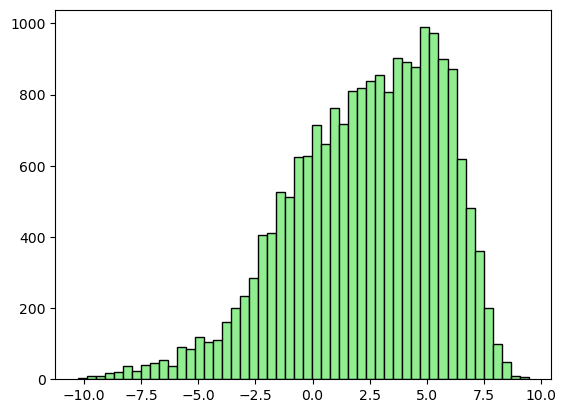

In [37]:
plt.hist(result["predicted_score"], color='lightgreen', ec='black', bins=50)

In [38]:
result = pd.concat([query_test
          , pd.DataFrame(prediction, columns = ["predicted_score"])]
          , axis=1)

In [39]:
print(result.shape)
result.head()

(20000, 10)


,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score
0,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_05_840839268,1,16.004101,Anserini,1,what us state bears the slogan the land enchan...,5.953219
1,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_06_203354916,2,15.715500,Anserini,1,what us state bears the slogan the land enchan...,5.636463
2,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_45_489369159,3,15.715499,Anserini,1,what us state bears the slogan the land enchan...,5.636463
3,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_50_676325639,4,14.983700,Anserini,1,what us state bears the slogan the land enchan...,4.759048
4,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_21_464076261,5,14.347200,Anserini,1,what us state bears the slogan the land enchan...,5.291733


In [40]:
result.to_csv("./output/query_test_result_TinyBERT-L-2-v2_CEBinaryClassificationEvaluator.csv"
                                       , index = False)

In [41]:
query_test.shape

(20000, 9)

In [42]:
result.shape

(20000, 10)

In [45]:
result.iloc[0]

query_id                                                      916247
query              what us state bears the slogan the land enchan...
used                                                              Q0
passage_id                              msmarco_passage_05_840839268
rank                                                               1
score                                                      16.004101
username                                                    Anserini
rel                                                                1
query_cleaned      what us state bears the slogan the land enchan...
predicted_score                                             5.953219
Name: 0, dtype: object

In [83]:
result[result["query_id"] == 916247]

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score
0,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_05_840839268,1,16.004101,Anserini,1,what us state bears the slogan the land enchan...,5.953219
1,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_06_203354916,2,15.715500,Anserini,1,what us state bears the slogan the land enchan...,5.636463
2,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_45_489369159,3,15.715499,Anserini,1,what us state bears the slogan the land enchan...,5.636463
3,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_50_676325639,4,14.983700,Anserini,1,what us state bears the slogan the land enchan...,4.759048
4,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_21_464076261,5,14.347200,Anserini,1,what us state bears the slogan the land enchan...,5.291733
5,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_50_676326055,6,14.297500,Anserini,1,what us state bears the slogan the land enchan...,6.077652
6,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_09_683772331,7,13.045700,Anserini,1,what us state bears the slogan the land enchan...,4.548508
7,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_32_845400104,8,13.045699,Anserini,1,what us state bears the slogan the land enchan...,4.548508
8,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_22_677091138,9,12.917000,Anserini,1,what us state bears the slogan the land enchan...,4.271601
9,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_00_583662759,10,12.832800,Anserini,1,what us state bears the slogan the land enchan...,2.821665


In [87]:
# Function for calculating average precision for a query
def average_precision(qid, topn = 10):
    
    # ========= for each query_id, do the following:
    #print(f"Started to work on query_id {qid}")
    # get passage_id (each query_id would have upto 10 passage_id)
    qresult = result.loc[result["query_id"] == qid, ["passage_id", "rel", "predicted_score"]]


    
    # sort rows so that passages with the highest similarity ranks as top 
    qresult.sort_values(by="predicted_score", ascending = False, inplace=True)

    # # Taking Top 10 documents for the evaluation
    ranking = qresult.head(topn)['rel'].values
    #display(qresult.head(topn))
    
    # # Calculating precision
    precision=[]
    for i in range(1,11):
      if ranking[i-1]:
        precision.append(np.sum(ranking[:i])/i)
    
    # If no relevant document in list then return 0
    if precision==[]:
      return 0
    #print(len(precision))
    #print(precision)
    avg_precision = np.mean(precision)
    #print("Avg precision: {}".format(avg_precision))
    return avg_precision#, len(precision), qresult.shape[0]

In [89]:
result["avg_precision"] = result.apply(lambda x: average_precision(x['query_id'])
                                    ,axis=1)

In [90]:
result["avg_precision"].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: avg_precision, dtype: float64

In [92]:
result.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score,avg_precision
0,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_05_840839268,1,16.004101,Anserini,1,what us state bears the slogan the land enchan...,5.953219,1.0
1,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_06_203354916,2,15.715500,Anserini,1,what us state bears the slogan the land enchan...,5.636463,1.0
2,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_45_489369159,3,15.715499,Anserini,1,what us state bears the slogan the land enchan...,5.636463,1.0
3,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_50_676325639,4,14.983700,Anserini,1,what us state bears the slogan the land enchan...,4.759048,1.0
4,916247,what us state bears the slogan the land enchan...,Q0,msmarco_passage_21_464076261,5,14.347200,Anserini,1,what us state bears the slogan the land enchan...,5.291733,1.0


In [91]:
print('Mean Average Precision=>', result["avg_precision"].mean())

Mean Average Precision=> 0.8705241320231795


In [93]:
result.to_csv("./output/query_test_result_TinyBERT-L-2-v2_CEBinaryClassificationEvaluator.csv"
                                       , index = False)